# Toy example

In [1]:
import bhad 
import utils as util
import numpy as np
import matplotlib.pyplot as plt

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [37]:

seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 1*10**4                     # sample size

# Specify first and second moments for each component  
bvt = util.mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(10000, 30)


In [38]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.0085

### Visualize the data:

In [39]:
#bvt.show2D(alpha = .45, edgecolor='k', save_plot = False)
#bvt.show3D(alpha = .45, edgecolor='k', save_plot = False)    # plot the first three dimensions

Reduce dimension for visualization only:

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

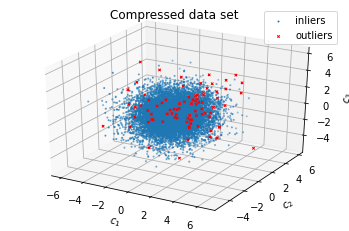

In [41]:
# Plot all the ground truth points together with the predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
plt.show();

### Model training

Discretize continuous features + train BHAD:

In [42]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    # if nbins = None, this will automatically select the optimal bin numbers 
    # based on the MAP estimate (but will make computation slower!)
    ('discrete' , util.discretize(nbins = None)),      # step only needed if continous features are present
    ('model', bhad.BHAD(contamination = 0.01))
])


In [52]:
y_pred = pipe.fit_predict(dataset)     

Used 30 numeric feature(s).
Determining optimal number of bins via Bayesian MAP estimate
Feature var0 using 29 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var1 using 31 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var2 using 29 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var3 using 32 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var4 using 30 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var5 using 26 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var6 using 23 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var7 using 31 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var8 using 29 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var9 using 32 bins
Determining optimal number of bins via Bayesian MAP estimate
Feature var10 using 26 bins
Det

In [53]:
scores = pipe.decision_function(dataset)
#scores = pipe.score_samples(dataset)

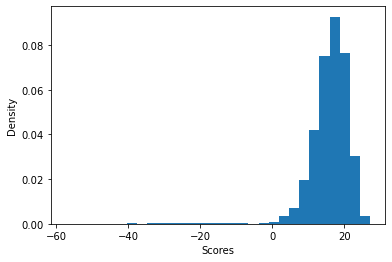

In [54]:
plt.hist(scores, density=True, bins=30)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Scores');

In [55]:
from sklearn.metrics import classification_report

# Make comparable to BHAD encoding
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(y_true, y_pred, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      9915
     Outlier       0.82      0.96      0.89        85

    accuracy                           1.00     10000
   macro avg       0.91      0.98      0.94     10000
weighted avg       1.00      1.00      1.00     10000



In [56]:
np.unique(y_true, return_counts=True)

(array([0, 1]), array([9915,   85], dtype=int64))

In [57]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([9900,  100], dtype=int64))